As a data scientist working for a bank, developing credit risk models to classify applicants as low-risk or high-risk clients is part of my daily routine.

A scorecard is a widely used tool for creating algorithms to compute applicants’ risk scores. In the age of big data, data scientists often face hundreds or even thousands of variables that can be used to train the model. Traditionally, model developers would rely on stepwise methods to iteratively add or remove variables until no further changes are warranted. What I find particularly convenient is using L1 regularization (also known as Lasso) and cross-validation to eliminate redundant variables and identify the best model.

In this article, I will explain the concepts of scorecards, Lasso, and cross-validation (hyperparameter tuning) and summarize how I apply these techniques to develop a scorecard in my day-to-day work.

## Scorecard

One of the key differences between a scorecard and logistic regression is that, in scorecards, you first bin the features and use the **Weight of Evidence (WOE)** instead of the original features to calculate the **Probability of Default (PD)**. In the end, you obtain a score from the scorecard rather than a probability. This means there is a procedure to convert the model-generated probability into an integer score. This allows your bank manager to discuss a credit score, rather than a confusing probability like **0.897**.

## Too Many Features

Today, we face an environment where there is an abundance of data rather than a shortage of it. During the modeling process, we need to select the most important features for our target and eliminate the superfluous ones. For example, some features can be highly correlated, and using only one of them is sufficient for the model. In statistical modeling, we refer to this phenomenon as **multicollinearity**. When estimating a regression model, multicollinearity can inflate the standard errors of the estimated parameters, leading to unstable or poor models.

In this example, I will introduce **L1 regularization**, which is used to reduce feature redundancy. Recently, I’ve been reading the book *"The Effects: An Introduction to Research Design and Causality"* by Nick Huntington-Klein. I appreciate how he explains penalized regression techniques, including L1 regularization:

> But these methods don’t just shrink coefficients uniformly; it sort of works with a coefficient “budget” and it spends wisely.

Below is the loss function that needs to be optimized in L1-regularized regression.

$$\text{Loss} = \text{Original Loss} + \lambda \sum |w_i|$$

Here:

- $\text{Original Loss}$ is the loss function without regularization (e.g., mean squared error; in logistic regression, it could be the binary cross-entropy loss).
- $\lambda$ is a regularization parameter that you can tune. It controls the strength of the penalty, and in later sections, we will use cross-validation to find the best $\lambda$.
- $\sum |w_i|$ is the sum of the absolute values of the coefficients $w_i$.

Typically, we need to standardize the data before applying L1 regularization. However, in the process of developing a scorecard, we don’t apply the model to the original features, but rather to the transformed **Weight of Evidence (WOE)**.
 
 $$WOE_i = \ln(\frac{py_i}{pn_i}) = \ln(\frac{\#y_i/\#y_T}{\#n_i/\#n_T})$$

In a way, this transformation already standardizes the features. Although I’m still unsure how the original designers of the first scorecard came up with such a transformation, I will continue to adhere to this tradition.



## How to Do It in Python

I will demonstrate how I would implement this in Python using simulated data. In practice, you may encounter datasets with millions of clients and thousands of features, but the methodology remains the same. Below, you can see the first 5 rows of the simulated data.

In [1]:
#| message: false
#| error: false
#| warning: false
import numpy as np
import pandas as pd
from optbinning import OptimalBinning, BinningProcess

from sklearn.datasets import make_classification
import matplotlib.pyplot as plt

# Parameters
n_samples = 10000  # Number of samples
n_features = 50  # Number of features
n_informative = 15  # Number of informative features
n_redundant = 2  # Number of redundant features
n_classes = 2  # Number of classes
weights = [0.9, 0.1]

# Generate the data
X, y = make_classification(n_samples=n_samples,
                           n_features=n_features,
                           n_informative=n_informative,
                           n_redundant=n_redundant,
                           n_classes=n_classes,
                           weights=weights,
                           random_state=77)

# Convert to DataFrame for easier manipulation
col_names = [f'feature_{i}' for i in range(n_features)]
df = pd.DataFrame(X, columns=col_names)
df['y'] = y

# Display the first few rows of the dataframe
df.head()

(CVXPY) Oct 17 03:26:57 PM: Encountered unexpected exception importing solver GLOP:
RuntimeError('Unrecognized new version of ortools (9.11.4210). Expected < 9.10.0. Please open a feature request on cvxpy to enable support for this version.')
(CVXPY) Oct 17 03:26:57 PM: Encountered unexpected exception importing solver PDLP:
RuntimeError('Unrecognized new version of ortools (9.11.4210). Expected < 9.10.0. Please open a feature request on cvxpy to enable support for this version.')


,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,y
0,3.080523,-2.222642,0.586273,0.165642,-0.680589,-0.073288,-0.428355,0.958035,-5.519702,0.474460,-0.743884,1.638282,0.592737,2.093693,-0.269527,2.330575,1.009629,-0.129033,-0.740598,1.268138,-1.096324,-0.720922,0.421576,-1.909183,-0.111677,2.100056,2.005894,0.681274,-0.697243,2.933464,-0.072685,-0.335503,-2.536013,-0.127543,1.738996,0.813571,0.287336,-1.289557,-0.498801,1.578175,-1.386176,0.137293,-2.154975,-0.734805,1.396048,5.968298,0.397864,1.010834,0.833587,0.536978,0
1,1.735613,4.247614,-0.156868,0.216549,-1.023063,2.152543,1.321979,0.747561,-0.975258,0.900816,0.652860,1.065369,-2.836512,-2.080872,-1.567230,3.466074,0.175695,2.404661,1.704029,-0.294990,-2.376430,1.236831,0.293541,-2.505189,0.400105,0.263577,-0.133667,-0.347520,-1.167439,-0.318959,0.586737,3.218929,-0.984331,0.301855,0.028315,-2.431508,0.266024,2.296546,0.592310,-0.401957,-4.049034,1.299570,-1.293430,0.958876,-0.284317,10.253337,-0.463766,0.086797,-0.197061,-1.106422,1
2,1.725620,1.331498,-0.810434,-0.959882,2.480232,-0.711417,-0.755270,0.460768,0.574454,1.879138,0.122072,0.200560,1.840448,2.162804,-1.074659,-0.276063,0.426977,0.954729,-5.320542,0.644956,-3.991067,2.264480,0.257884,-0.659211,-0.053604,-0.152015,-0.092462,1.468191,1.994039,-0.164820,0.463419,0.643844,1.742916,0.062626,-1.272052,-0.262562,-0.880121,-0.229472,-0.053960,0.270332,-0.321088,-0.015032,0.096618,-0.073374,-0.347204,3.380912,-1.821082,0.170916,-0.076520,0.805564,0
3,1.010512,-5.338740,1.233311,0.662510,0.681362,0.218692,2.307052,0.575638,-0.093026,-1.002429,0.331628,-1.710618,3.481915,-3.586467,0.794994,0.659143,-0.793541,1.983868,-10.956005,-1.038129,2.078974,0.281654,-0.372604,-0.667919,0.513026,-1.104436,2.091840,-0.086955,-2.303168,-1.517275,2.051592,0.443803,0.699985,-0.302881,0.544646,-3.550123,-0.281879,-1.294549,1.675871,0.980036,-2.557969,1.522615,0.327769,2.257158,0.496460,7.190824,-3.350632,0.806324,0.967106,0.143677,0
4,-1.302434,2.176737,-0.808271,0.774462,-0.592410,-0.158665,-0.761512,-0.222382,-0.013585,1.215514,0.490144,0.618167,0.921700,-2.737353,1.069421,-2.575380,-0.838665,3.364669,-1.779668,-1.283335,-2.393755,-0.338372,0.136575,0.521520,-0.078517,0.277676,-0.089377,0.722677,1.785885,-0.046230,0.073333,2.018320,-2.263093,-1.246910,-0.262614,-0.090771,1.557224,-0.997555,-0.476358,0.463069,-0.413500,1.174782,-0.913200,-0.156488,-0.715478,1.120039,-5.737395,0.263808,-0.485977,0.016630,0


We can plot the distribution of the target variable. Additionally, we can visualize the distribution of a specific feature for different target values using plots like violin plots or box plots.

<Axes: >

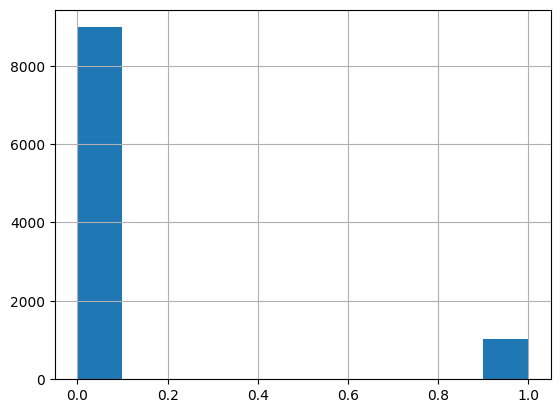

In [3]:
#| fig-cap: "The Distribution of the Response Variable"
#| label: fig-hist-y
df.y.hist()

Before modeling, some exploratory data analysis (EDA) is essential to better understand the data. Since the data we have here is simulated, I will demonstrate some visualizations that we can create during the EDA phase before building the model.

<positron-console-cell-4>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

<positron-console-cell-4>:6: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='count'` for the same effect.


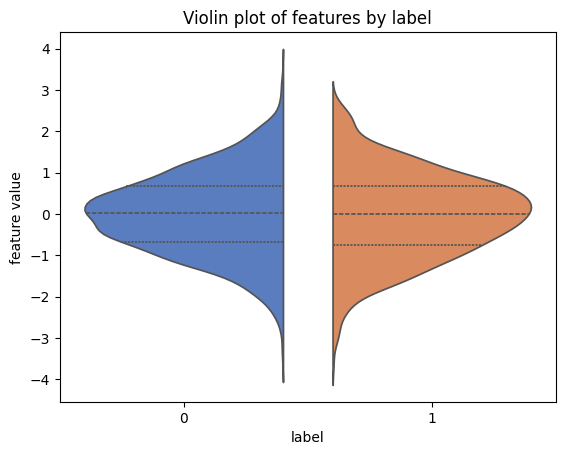

In [4]:
#| warning: false
#| fig-cap: "Violin Plot of Feature 3 by Target Label"
#| label: fig-violin-plot
import seaborn as sns

# Create a violin plot with customizations
sns.violinplot(x="y"
               , y="feature_3"
               , data=df
               , split=True
               , inner="quartile"
               , palette="muted"
               , scale="count")

# Add a title and labels
plt.title('Violin plot of features by label')
plt.xlabel('label')
plt.ylabel('feature value')

# Show the plot
plt.show()

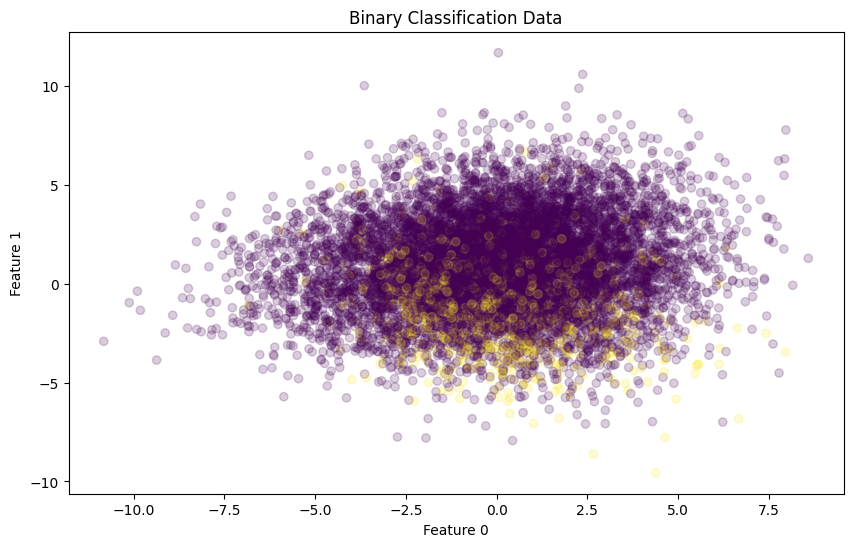

In [5]:
#| warning: false
#| fig-cap: "Some Scatter Plot"
#| label: fig-scatter-plot
# Visualize the first two features
plt.figure(figsize=(10, 6))
plt.scatter(df['feature_20'], df['feature_32'], c=df['y'], cmap='viridis', alpha=0.2)
plt.xlabel('Feature 0')
plt.ylabel('Feature 1')
plt.title('Binary Classification Data')
plt.show()

Before running the model, the data must be split into training, validation, and test sets.

In [6]:
#| code-fold: false
# split into training, validation and test set

from sklearn.model_selection import train_test_split

# # Split the data into training and validation sets
# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# df_test is going to be our left out test sample
df_train_, df_test = train_test_split(df
                 , test_size=0.15
                 , random_state=77)

df_train, df_val = train_test_split(df_train_
                 , test_size=0.2
                 , random_state=77)

print(f'The sizes of train, validation and test sets are {df_train.shape[0]}, {df_val.shape[0]}, {df_test.shape[0]}.')

The sizes of train, validation and test sets are 6800, 1700, 1500.


## The Binning Process

We will use [OptBinning](http://gnpalencia.org/optbinning/) to handle the binning process. If you’re interested, you can visit the homepage of the package. Below is an introduction from their website:

> The optimal binning is the optimal discretization of a variable into bins given a discrete or continuous numeric target. OptBinning is a library written in Python implementing a rigorous and flexible mathematical programming formulation to solve the optimal binning problem for a binary, continuous and multiclass target type, incorporating constraints not previously addressed.

The `OptBinning` package simplifies the binning process significantly. I only need to set parameters such as selection criteria and binning sizes. One thing to note when using `OptBinning` is that you must set `metric_missing = 'empirical'`. If you don't, it will assign 0 to all missing values as their $WOE$.

In [7]:
#| echo: false
# from ydata_profiling import ProfileReport

# profile = ProfileReport(df, title="Pandas Profiling Report")
# profile

# # Convert to DataFrame for easier manipulation (optional)
# df_train = pd.DataFrame(X_train, columns=[f'feature_{i}' for i in range(n_features)])
# df_train['y'] = y_train

# df_val = pd.DataFrame(X_val, columns=[f'feature_{i}' for i in range(n_features)])
# df_val['y'] = y_val

In [8]:
#| code-fold: false
#| tbl-cap: "The WOE of All the Features after Binning"
#| label: tbl-woe

# Display the shape of the resulting datasets
print(f'Training set shape: {df_train.shape}')
print(f'Validation set shape: {df_val.shape}')


selection_criteria = {"iv": {"min": 0.02}}

binning_process = BinningProcess(variable_names=col_names
                                 , min_prebin_size=0.01
                                 , max_n_bins=None
                                 , min_bin_size=0.05
                                 , selection_criteria=selection_criteria
                                 , n_jobs=None)

variable_names = col_names

binning_process.fit(df_train.loc[:, variable_names], df_train.loc[:, 'y'])

df_train_woe = binning_process.transform(df_train.loc[:, variable_names]
                                         , metric='woe'
                                         , metric_missing='empirical')

df_train_woe.head()

Training set shape: (6800, 51)
Validation set shape: (1700, 51)


,feature_0,feature_1,feature_4,feature_9,feature_12,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_29,feature_31,feature_32,feature_34,feature_35,feature_36,feature_37,feature_42,feature_45,feature_46,feature_48
3803,-0.198717,-0.00303,-0.104984,-0.022752,0.039165,0.050108,-0.096567,0.301457,0.070496,0.118410,-0.296105,-0.027841,0.258165,2.065892,0.337535,0.009863,0.013160,-0.005671,0.318104,0.039315,-0.359713,-0.103907
8835,-0.488738,-0.00303,0.155568,-0.022752,-0.050594,0.116010,0.477915,0.413342,0.056234,0.495249,-0.182112,-0.091207,0.258165,2.065892,0.337535,-0.018696,0.013160,-0.316992,0.012626,0.306719,0.622712,-0.103907
5160,-0.089629,-0.05241,-0.097076,-0.022752,0.039165,0.050108,0.477915,-0.224455,0.056234,-0.057077,-0.182112,-0.091207,0.258165,0.165780,-0.046789,-0.018696,-0.051565,0.331291,0.012626,0.306719,0.180705,0.068626
3671,0.268837,-0.05241,-0.139101,-0.022752,0.134657,0.050108,-0.096567,0.301457,-0.130562,-0.057077,0.272488,-0.027841,-0.120298,2.065892,-0.229642,-0.018696,0.013160,-0.316992,-0.289836,-0.925294,-0.919692,-0.103907
3082,-0.198717,-0.05241,0.155568,-0.022752,-0.050594,-0.182615,-0.066231,0.413342,-0.209557,0.118410,-0.614764,-0.091207,-0.120298,0.865998,-0.046789,-0.018696,0.013160,-0.005671,0.012626,0.039315,-0.127682,0.068626


It is also possible to view the binning table for each feature. The following code will display the binning table for the first feature.

In [9]:
#| code-fold: false
#| tbl-cap: "Example Binning Table for One Feature"
#| label: tbl-binning-example
variables_bin_selected = binning_process.get_support(names=True)

# the binning table for one variable
binning_process.get_binned_variable(variables_bin_selected[0]).binning_table.build(add_totals=True)

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, -2.91)",602,0.088529,507,95,0.157807,-0.488738,0.025606,0.003169
1,"[-2.91, -2.26)",394,0.057941,350,44,0.111675,-0.089629,0.000482,0.000060
2,"[-2.26, -1.78)",432,0.063529,405,27,0.062500,0.544678,0.015190,0.001876
3,"[-1.78, -0.44)",1548,0.227647,1423,125,0.080749,0.268837,0.014786,0.001843
4,"[-0.44, 0.96)",1597,0.234853,1453,144,0.090169,0.1482,0.004863,0.000607
5,"[0.96, 2.15)",999,0.146912,884,115,0.115115,-0.123847,0.002367,0.000296
6,"[2.15, inf)",1228,0.180588,1077,151,0.122964,-0.198717,0.007714,0.000963
7,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
8,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,6800,1.000000,6099,701,0.103088,,0.071009,0.008814


In [10]:
binning_process.get_binned_variable(variables_bin_selected[0]).binning_table.analysis()

binning_process.get_binned_variable(variables_bin_selected[4]).binning_table.iv

binning_process.get_binned_variable(variables_bin_selected[4]).binning_table.quality_score

---------------------------------------------
OptimalBinning: Binary Binning Table Analysis
---------------------------------------------

  General metrics

    Gini index               0.14690489
    IV (Jeffrey)             0.07100853
    JS (Jensen-Shannon)      0.00881356
    Hellinger                0.00884463
    Triangular               0.03501004
    KS                       0.05792980
    HHI                      0.17640489
    HHI (normalized)         0.07345550
    Cramer's V               0.08184735
    Quality score            0.05486914

  Monotonic trend                valley

  Significance tests

    Bin A  Bin B  t-statistic  p-value  P[A > B]  P[B > A]
        0      1     4.220505 0.039938  0.982381  0.017619
        1      2     6.342284 0.011789  0.994754  0.005246
        2      3     1.587066 0.207746  0.092064  0.907936
        3      4     0.891725 0.345010  0.171784  0.828216
        4      5     4.258142 0.039063  0.020053  0.979947
        5      6     0.3

0.0019503684739798721

## Running the Logistic Regression

After the binning process, features with an information value less than 0.02 have already been removed. To further refine the model, I will use logistic regression with L1 regularization (Lasso). The key question now is: which $\lambda$ value should I use? To determine the optimal $\lambda$, I will use cross-validation to select the best value and identify the best model.

In [11]:
#| code-fold: false
# logistic regression

from sklearn.model_selection import GridSearchCV

C_grid = np.logspace(-4, 4, 10)

from sklearn.linear_model import LogisticRegression

model = LogisticRegression(penalty='l1', solver='liblinear')

from sklearn.metrics import roc_auc_score

param_grid = {'C': C_grid}

grid_search = GridSearchCV(model, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)

grid_search.fit(df_train_woe, df_train.loc[:, 'y'])

best_model = grid_search.best_estimator_
best_C = grid_search.best_params_['C']

df_coef = pd.DataFrame({'var': df_train_woe.columns, 'coef': best_model.coef_[0]})

df_coef

,var,coef
0,feature_0,-0.575783
1,feature_1,-0.994414
2,feature_4,-1.068349
3,feature_9,-0.944433
4,feature_12,-0.957070
5,feature_15,-1.096867
6,feature_16,-0.902367
7,feature_17,-0.794964
8,feature_18,0.065640
9,feature_19,-0.853116


The final model retains 22 features, but there is one more important consideration. Due to how the $WOE$ values are calculated, the model parameters should all be negative. If you're interested in understanding why, I can write a separate article to explain it. In this case, we need to remove `feature_18` and rerun the model until all the parameters are negative. The corresponding code is provided in the following sections.

In [12]:
#| code-fold: false

vars_to_delete = df_coef.loc[df_coef.coef > 0, 'var'].tolist()
vars_to_keep = df_coef.loc[df_coef.coef < 0, 'var'].tolist()

len(vars_to_delete), len(vars_to_keep)

(1, 21)

After the first round of training, I can evaluate the model's performance while also determining the best $\lambda$ value. In the subsequent iterations of training, I will continue using the best $\lambda$ parameter obtained from the previous steps.

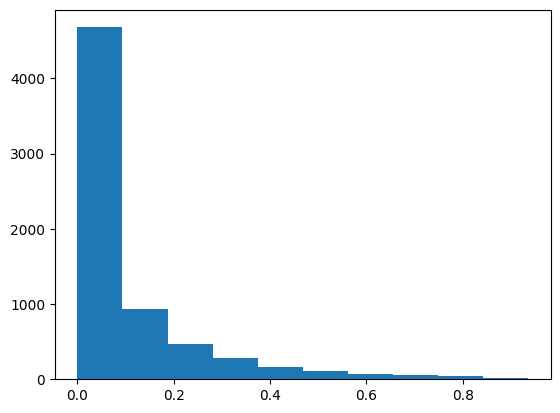

In [23]:
#| message: false
#| fig-cap: "Probability Distribution"
#| label: fig-prob
# 分数分布
import matplotlib.pyplot as plt

plt.hist(best_model.predict_proba(df_train_woe)[:, 1]);

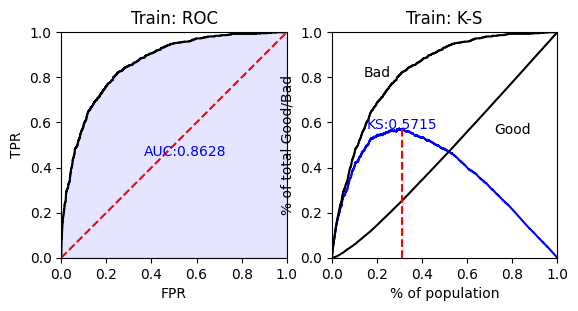

In [24]:
#| code-fold: false
#| fig-cap: "Performance on the Trainning Data"
#| label: fig-perf-train

# performance
import scorecardpy as sc
sc.perf_eva(df_train.loc[:, 'y'], best_model.predict_proba(df_train_woe)[:, 1], plot_type=['roc', 'ks'], title='Train');

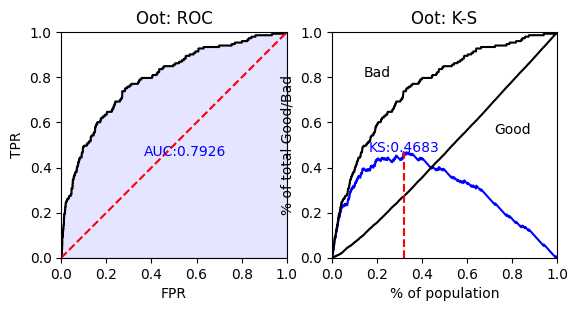

In [26]:
#| code-fold: false
#| fig-cap: "Performance on the Testing Data"
#| label: fig-perf-test
df_test_woe = binning_process.transform(df_test.loc[:, variable_names]
                                       , metric='woe'
                                       , metric_missing='empirical')
sc.perf_eva(df_test.loc[:, 'y'], best_model.predict_proba(df_test_woe)[:, 1], plot_type=['roc', 'ks'], title='Oot');

## Take Care of Those Positive Coefficients

Although only one feature exhibits an unreasonable coefficient direction, the general approach is to iteratively remove such features and retrain the model until all coefficients are negative. The following code will accomplish this task. Additionally, the predicted probabilities will be transformed into credit scores.

iteration 1
remaining variable number 21


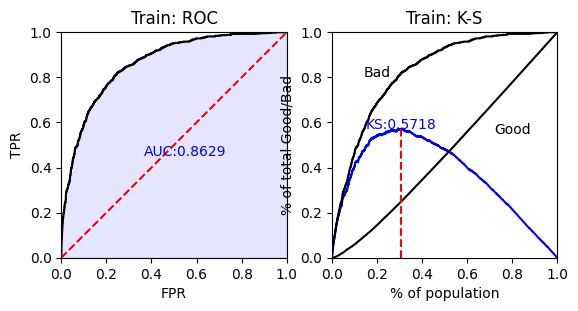

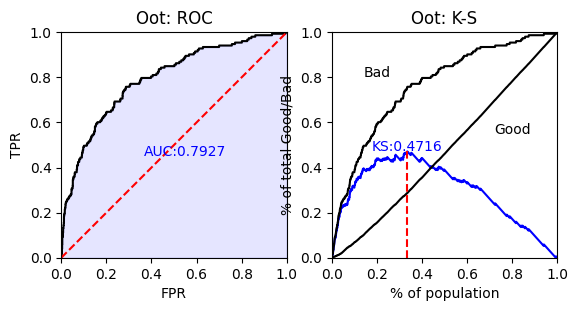

In [19]:
#| code-fold: false

# iteratively delete features with positive coefficients

pdo = 20
target_score = 500
target_odds = 1 / 20
i = 1

while True:
    print(f'iteration {i}')
    initial_n_vars = len(vars_to_keep)

    print(f'remaining variable number {initial_n_vars}')

    model_exp3 = LogisticRegression(solver='liblinear', penalty='l1', C=best_C)
    model_exp3.fit(df_train_woe.loc[:, vars_to_keep], df_train.loc[:, 'y'])

    df_coef_exp3 = pd.DataFrame({'var': vars_to_keep, 'coef': model_exp3.coef_[0]})
    df_coef_exp3.merge(df_coef, how='left', on='var')

    sc.perf_eva(df_train.loc[:, 'y'], model_exp3.predict_proba(df_train_woe.loc[:, vars_to_keep])[:, 1], plot_type=['roc', 'ks'],
                title='Train')
    sc.perf_eva(df_test.loc[:, 'y'], model_exp3.predict_proba(df_test_woe.loc[:, vars_to_keep])[:, 1], plot_type=['roc', 'ks'], title='Oot')

    A = target_score - pdo / np.log(2) * np.log(target_odds)

    score_intercept = A - pdo / np.log(2) * model_exp3.intercept_[0]

    list_score_table = []

    for var_bin in vars_to_keep:
        df_binning = binning_process.get_binned_variable(var_bin).binning_table.build(add_totals=False)

        df_binning.loc[:, 'Variable'] = var_bin

        df_binning.loc[:, 'Coef'] = df_coef_exp3.loc[df_coef_exp3.loc[:, 'var'] == var_bin, 'coef'].values[0]

        df_binning.loc[:, 'score'] = -pdo / np.log(2) * df_binning.loc[:, 'Coef'] * df_binning.loc[:, 'WoE']

        list_score_table.append(df_binning)

    df_score_table = pd.concat(list_score_table, axis=0)

    df_var_score_range = df_score_table.groupby('Variable', as_index=False).aggregate({'score': ['min', 'max']})
    df_var_score_range.columns = ['Variable', 'score_min', 'score_max']

    final_n_vars = len(vars_to_keep)

    if initial_n_vars == final_n_vars:
        break

## The Final Scorecard

Fortunately, after one iteration, all the features align with the same direction. We can obtain the final scorecard simply by exporting the `df_score_table`.

In [20]:
#| code-fold: false
#| tbl-cap: "My Final Scorecard Table"
#| label: tbl-final-table
df_score_table

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS,Variable,Coef,score
0,"(-inf, -2.91)",602,0.088529,507,95,0.157807,-0.488738,0.025606,0.003169,feature_0,-0.573400,-8.086092
1,"[-2.91, -2.26)",394,0.057941,350,44,0.111675,-0.089629,0.000482,0.000060,feature_0,-0.573400,-1.482892
2,"[-2.26, -1.78)",432,0.063529,405,27,0.062500,0.544678,0.015190,0.001876,feature_0,-0.573400,9.011608
3,"[-1.78, -0.44)",1548,0.227647,1423,125,0.080749,0.268837,0.014786,0.001843,feature_0,-0.573400,4.447858
4,"[-0.44, 0.96)",1597,0.234853,1453,144,0.090169,0.148200,0.004863,0.000607,feature_0,-0.573400,2.451947
...,...,...,...,...,...,...,...,...,...,...,...,...
1,"[-1.65, 0.05)",3240,0.476471,2926,314,0.096914,0.068626,0.002184,0.000273,feature_48,-0.910488,1.802893
2,"[0.05, 0.20)",415,0.061029,389,26,0.062651,0.542111,0.014470,0.001787,feature_48,-0.910488,14.241865
3,"[0.20, inf)",2794,0.410882,2478,316,0.113099,-0.103907,0.004623,0.000578,feature_48,-0.910488,-2.729765
4,Special,0,0.000000,0,0,0.000000,0.000000,0.000000,0.000000,feature_48,-0.910488,0.000000
